# Sarsa
Sarsa算法是表格型方法的一种。自举式更新，睡觉哦on-policy的方法。通过结合时序差分和蒙特卡洛方法估计价值函数。
- 蒙特卡洛
$$ 
V(s_t)=V(s_t)+\alpha (G_t - V(s_t))
$$
- 时序差分
假设做的是n阶时序差分，$n=\infty$ 表示蒙特卡洛方法。
$$
G_t^{(n)}=r_{t+1}+\gamma r_{t+2}+\gamma^2 r_{t+3}+...+\gamma^{n-1}r_{t+n}+\gamma^n V(s_{t+n})
$$
$$
TD(n):V(s_t)=V(s_t)+\alpha (G_t^{(n)} - V(s_t)) 
$$
- Sarsa
将原本的**单步**时序差分方法更新V的过程，变成更新Q，即
$$
Q(s_t,a_t)\leftarrow Q(s_t,a_t)+\alpha (r_{t+1} + \gamma Q(s_{t+1},a_{t+1}) - Q(s_t,a_t))
$$
Sarsa直接更新Q-table，得到Q-table之后就可以更新策略。每次更新需要知道当前状态、当前动作、奖励、下一步状态、下一步动作。

## 导入相关的包

In [39]:
import numpy as np
import torch
from collections import defaultdict
import math
import dill
import gym
import turtle
import sys
import os
import datetime
import argparse
import matplotlib.pyplot as plt
import seaborn as sns

## 定义Sarsa算法类
输入为动作数

In [40]:
class Sarsa(object):
    def __init__(self, n_actions, cfg):
        self.n_actions = n_actions
        self.lr = cfg.lr
        self.gamma = cfg.gamma # 折扣因子
        self.sample_count = 0 # 记录已经采样的次数
        self.epsilon_start = cfg.epsilon_start # 贪心策略epsilon的初始值0.95
        self.epsilon_end = cfg.epsilon_end # 贪心策略epsilon的终止值0.01
        self.epsilon_decay = cfg.epsilon_decay # 贪心策略epsilon的衰减率
        self.Q = defaultdict(lambda: np.zeros(self.n_actions)) # Q table
    
    def sample_action(self, state):
        '''从当前状态采样动作'''
        self.sample_count += 1
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.sample_count / self.epsilon_decay) # 指数衰减的贪心策略epsilon
        best_action = np.argmax(self.Q[state])
        action_probs = np.ones(self.n_actions, dtype=float) * self.epsilon / self.n_actions
        action_probs[best_action] += (1.0 - self.epsilon) # 保证概率只和为1
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        return action
    
    def predict_action(self, state):
        return np.argmax(self.Q[state])
    
    def update(self, state, action, reward, next_state, next_action, done):
        '''更新Q表格'''
        Q_predict = self.Q[state][action]
        if done:
            Q_target = reward
        else:
            Q_target = reward + self.gamma * self.Q[next_state][next_action] # 与Qlearning不同，Sarsa用下一步的动作对应的Q值进行更新
        self.Q[state][action] += self.lr * (Q_target - Q_predict)
    
    def save(self, path):
        '''把Q表格的数据保存到本地文件'''
        #import dill
        torch.save(
            obj=self.Q,
            f=path+"sarsa_model.pkl",
            pickle_protocol=dill # dill是pickle的扩展库，支持更复杂的对象序列化
            )
        
    def load(self, path):
        '''从文件中读取数据到Q表格
        '''
        self.Q = torch.loaf(f=path+"sarsa_model.pkl", pickle_protocol=dill)



## 定义训练
和Q learning差别不大

In [41]:
def train(cfg, env, agent):
    '''
    - cfg: 配置参数
    - env: 环境
    - agent: 算法
    '''
    print("开始训练！")
    print(f'环境：{cfg.env_name}, 算法：{cfg.algo_name}, 设备：{cfg.device}')
    rewards = [] # 记录奖励
    for i_ep in range(cfg.train_eps):
        ep_reward = 0 # 一轮episode的reward
        state = env.reset() # 重置环境, 重新开一局（即开始新的一个episode）
        action = agent.sample_action(state)
        while True:
            action = agent.sample_action(state) # 根据算法采样一个动作
            next_state, reward, done, _ = env.step(action) # 与环境进行一个交互
            next_action = agent.sample_action(next_state)
            agent.update(state, action, reward, next_state, next_action, done) # Sarsa算法更新
            state = next_state
            action = next_action
            ep_reward += reward
            if done:
                break
        rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.1f}，Epsilon：{agent.epsilon:.3f}")
    print("完成训练！")
    return {"rewards": rewards}

def test(cfg, env, agent):
    print("开始测试！")
    print(f"环境：{cfg.env_name}, 算法：{cfg.algo_name}, 设备：{cfg.device}")
    rewards = [] # 记录所有回合的episode奖励
    for i_ep in range(cfg.test_eps):
        ep_reward = 0 # 一轮episode的reward
        state = env.reset()
        while True:
            action = agent.predict_action(state) # 根据算法选择一个动作
            next_state, reward, done, _ = env.step(action) # 与环境进行一个交互
            state = next_state # 更新状态
            ep_reward += reward
            if done:
                break
        rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg.test_eps}，奖励：{ep_reward:.1f}")
    print("完成测试！")
    return {"rewards": rewards}

## 定义环境

In [42]:
#import gym
#import numpy as np
#import turtle

#from envs.wrapper import FrozenLakeWrapper

def GridWorld(gridmap=None, is_slippery=False):
    if gridmap is None:
        gridmap = ['SFFF', 'FHFH', 'FFFH', 'HFFG']
    env = gym.make("FrozenLake-v0", desc=gridmap, is_slippery=is_slippery)
    env = FrozenLakeWrapper(env)
    return env

#'''
class FrozenLakeWrapper(gym.Wrapper):
    def __init__(self, env):
        '''定义一个Wrapper修饰环境'''
        gym.Wrapper.__init__(self, env)
        self.max_y = env.desc.shape[0]
        self.max_x = env.desc.shape[1]
        self.t = None
        self.unit = 50
    
    def draw_box(self, x, y, fillcolor='', line_color='gray'):
        # 绘制盒子
        self.t.up()
        self.t.goto(x * self.unit, y * self.unit)
        self.t.color(line_color)
        self.t.fillcolor(fillcolor)
        self.t.setheading(90)
        self.t.down()
        self.t.begin_fill()
        for _ in range(4):
            self.t.forward(self.unit)
            self.t.right(90)
        self.t.end_fill()

    def move_player(self, x, y):
        # 移动玩家
        self.t.up()
        self.t.setheading(90)
        self.t.fillcolor('red')
        self.t.goto((x + 0.5) * self.unit, (y + 0.5) * self.unit)
    
    def render(self):
        # 渲染
        if self.t == None:
            self.t = turtle.Turtle()
            self.wn = turtle.Screen()
            self.wn.setup(self.unit * self.max_x + 100,
                          self.unit * self.max_y + 100)
            self.wn.setworldcoordinates(0, 0, self.unit * self.max_x,
                                        self.unit * self.max_y)
            self.t.shape('circle')
            self.t.width(2)
            self.t.speed(0)
            self.t.color('gray')
            for i in range(self.desc.shape[0]):
                for j in range(self.desc.shape[1]):
                    x = j
                    y = self.max_y - 1 - i
                    if self.desc[i][j] == b'S':  # Start
                        self.draw_box(x, y, 'white')
                    elif self.desc[i][j] == b'F':  # Frozen ice
                        self.draw_box(x, y, 'white')
                    elif self.desc[i][j] == b'G':  # Goal
                        self.draw_box(x, y, 'yellow')
                    elif self.desc[i][j] == b'H':  # Hole
                        self.draw_box(x, y, 'black')
                    else:
                        self.draw_box(x, y, 'white')
            self.t.shape('turtle')

        x_pos = self.s % self.max_x
        y_pos = self.max_y - 1 - int(self.s / self.max_x)
        self.move_player(x_pos, y_pos)

class CliffWalkingWrapper(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.t = None
        self.unit = 50
        self.max_x = 12
        self.max_y = 4

    def draw_x_line(self, y, x0, x1, color='gray'):
        assert x1 > x0
        self.t.color(color)
        self.t.setheading(0)
        self.t.up()
        self.t.goto(x0, y)
        self.t.down()
        self.t.forward(x1 - x0)

    def draw_y_line(self, x, y0, y1, color='gray'):
        assert y1 > y0
        self.t.color(color)
        self.t.setheading(90)
        self.t.up()
        self.t.goto(x, y0)
        self.t.down()
        self.t.forward(y1 - y0)

    def draw_box(self, x, y, fillcolor='', line_color='gray'):
        self.t.up()
        self.t.goto(x * self.unit, y * self.unit)
        self.t.color(line_color)
        self.t.fillcolor(fillcolor)
        self.t.setheading(90)
        self.t.down()
        self.t.begin_fill()
        for i in range(4):
            self.t.forward(self.unit)
            self.t.right(90)
        self.t.end_fill()

    def move_player(self, x, y):
        self.t.up()
        self.t.setheading(90)
        self.t.fillcolor('red')
        self.t.goto((x + 0.5) * self.unit, (y + 0.5) * self.unit)

    def render(self):
        if self.t == None:
            self.t = turtle.Turtle()
            self.wn = turtle.Screen()
            self.wn.setup(self.unit * self.max_x + 100,
                          self.unit * self.max_y + 100)
            self.wn.setworldcoordinates(0, 0, self.unit * self.max_x,
                                        self.unit * self.max_y)
            self.t.shape('circle')
            self.t.width(2)
            self.t.speed(0)
            self.t.color('gray')
            for _ in range(2):
                self.t.forward(self.max_x * self.unit)
                self.t.left(90)
                self.t.forward(self.max_y * self.unit)
                self.t.left(90)
            for i in range(1, self.max_y):
                self.draw_x_line(
                    y=i * self.unit, x0=0, x1=self.max_x * self.unit)
            for i in range(1, self.max_x):
                self.draw_y_line(
                    x=i * self.unit, y0=0, y1=self.max_y * self.unit)

            for i in range(1, self.max_x - 1):
                self.draw_box(i, 0, 'black')
            self.draw_box(self.max_x - 1, 0, 'yellow')
            self.t.shape('turtle')

        x_pos = self.s % self.max_x
        y_pos = self.max_y - 1 - int(self.s / self.max_x)
        self.move_player(x_pos, y_pos)
#'''

### 创建环境和智能体

In [43]:
def env_agent_config(cfg, seed=1):
    '''创建环境和智能体
    Args:
        cfg: 配置参数
        seed: 随机种子
    Returns:
        env: 环境
        agent: 智能体
    '''
    env = gym.make(cfg.env_name)
    env = CliffWalkingWrapper(env)
    env.seed(seed)
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    print(f"状态数：{n_states}, 动作数：{n_actions}")
    agent = Sarsa(n_actions, cfg)
    return env, agent

## 设置参数

In [44]:
#import datetime
#import argparse
#import matplotlib.pyplot as plt
#import seaborn as sns

def get_args():
    """设置参数
    """
    curr_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # 获取当前时间
    parser = argparse.ArgumentParser(description="hyperpaparameter")
    parser.add_argument("--algo_name", default="Sarsa", type=str, help="算法名称")
    parser.add_argument("--env_name", default="CliffWalking-v0", type=str, help="环境名称")
    parser.add_argument("--train_eps", default=400, type=int, help="训练回合数")
    parser.add_argument('--test_eps',default=20,type=int,help="episodes of testing") # 测试的回合数
    parser.add_argument('--gamma',default=0.90,type=float,help="discounted factor") # 折扣因子
    parser.add_argument('--epsilon_start',default=0.95,type=float,help="initial value of epsilon") #  e-greedy策略中初始epsilon
    parser.add_argument('--epsilon_end',default=0.01,type=float,help="final value of epsilon") # e-greedy策略中的终止epsilon
    parser.add_argument('--epsilon_decay',default=300,type=int,help="decay rate of epsilon") # e-greedy策略中epsilon的衰减率
    parser.add_argument('--lr',default=0.1,type=float,help="learning rate")
    parser.add_argument('--device',default='cpu',type=str,help="cpu or cuda")          
    args = parser.parse_args([])                          
    return args

def smooth(data, weight=0.9):  
    '''用于平滑曲线，类似于Tensorboard中的smooth

    Args:
        data (List):输入数据
        weight (Float): 平滑权重，处于0-1之间，数值越高说明越平滑，一般取0.9

    Returns:
        smoothed (List): 平滑后的数据
    '''
    last = data[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,cfg, tag='train'):
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{tag}ing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()
    plt.show()

## 开始训练
Sarsa收敛速度更快，但是比Q-learning慢很多，因为Sarsa需要计算Q值，而Q-learning只需要计算一个Q值。

状态数：48, 动作数：4
开始训练！
环境：CliffWalking-v0, 算法：Sarsa, 设备：cpu
回合：1/400，奖励：-2142.0，Epsilon：0.013
回合：2/400，奖励：-116.0，Epsilon：0.011
回合：3/400，奖励：-214.0，Epsilon：0.010
回合：4/400，奖励：-178.0，Epsilon：0.010
回合：5/400，奖励：-178.0，Epsilon：0.010
回合：6/400，奖励：-172.0，Epsilon：0.010
回合：7/400，奖励：-91.0，Epsilon：0.010
回合：8/400，奖励：-298.0，Epsilon：0.010
回合：9/400，奖励：-180.0，Epsilon：0.010
回合：10/400，奖励：-201.0，Epsilon：0.010
回合：11/400，奖励：-21.0，Epsilon：0.010
回合：12/400，奖励：-205.0，Epsilon：0.010
回合：13/400，奖励：-217.0，Epsilon：0.010
回合：14/400，奖励：-154.0，Epsilon：0.010
回合：15/400，奖励：-73.0，Epsilon：0.010
回合：16/400，奖励：-117.0，Epsilon：0.010
回合：17/400，奖励：-108.0，Epsilon：0.010
回合：18/400，奖励：-149.0，Epsilon：0.010
回合：19/400，奖励：-119.0，Epsilon：0.010
回合：20/400，奖励：-122.0，Epsilon：0.010
回合：21/400，奖励：-55.0，Epsilon：0.010
回合：22/400，奖励：-85.0，Epsilon：0.010
回合：23/400，奖励：-123.0，Epsilon：0.010
回合：24/400，奖励：-39.0，Epsilon：0.010
回合：25/400，奖励：-215.0，Epsilon：0.010
回合：26/400，奖励：-121.0，Epsilon：0.010
回合：27/400，奖励：-32.0，Epsilon：0.010
回合：28/400，奖励：-78.0，Epsilon：0.010
回合：29/4

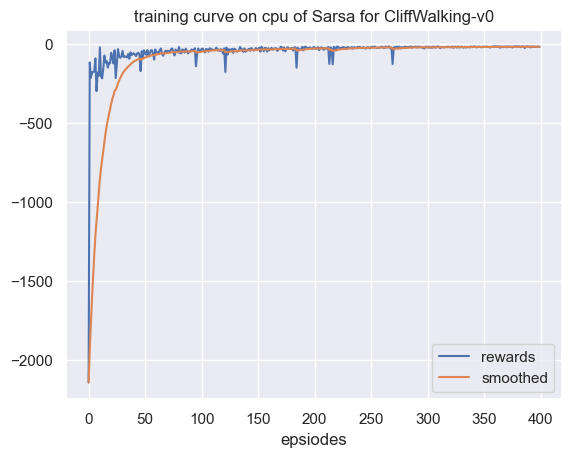

开始测试！
环境：CliffWalking-v0, 算法：Sarsa, 设备：cpu
回合：1/20，奖励：-15.0
回合：2/20，奖励：-15.0
回合：3/20，奖励：-15.0
回合：4/20，奖励：-15.0
回合：5/20，奖励：-15.0
回合：6/20，奖励：-15.0
回合：7/20，奖励：-15.0
回合：8/20，奖励：-15.0
回合：9/20，奖励：-15.0
回合：10/20，奖励：-15.0
回合：11/20，奖励：-15.0
回合：12/20，奖励：-15.0
回合：13/20，奖励：-15.0
回合：14/20，奖励：-15.0
回合：15/20，奖励：-15.0
回合：16/20，奖励：-15.0
回合：17/20，奖励：-15.0
回合：18/20，奖励：-15.0
回合：19/20，奖励：-15.0
回合：20/20，奖励：-15.0
完成测试！


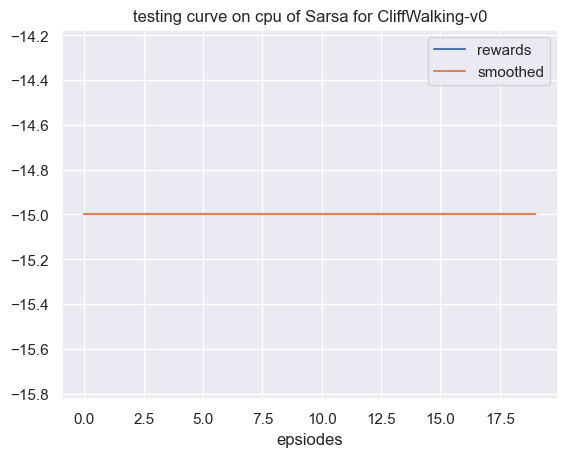

In [45]:
# 获取参数
cfg = get_args() 
# 训练
env, agent = env_agent_config(cfg)
res_dic = train(cfg, env, agent)
 
plot_rewards(res_dic['rewards'], cfg, tag="train")  
# 测试
res_dic = test(cfg, env, agent)
plot_rewards(res_dic['rewards'], cfg, tag="test")  # 画出结果